This file tests different scheduling rates to see if it improves the model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
""" This is the part of the file where it gets the data, transforms it into numbers, 
normalizes it, transfroms to tensors and gets the training and testing data"""

#Import the Data set
df = pd.read_csv("data\\Traffic.csv")

#Get the inputs and target
X = df.drop(columns="Traffic Situation")
y = df["Traffic Situation"]

#There is only 31 days in the data, so we project it onto this circle
X["day_of_the_month_sin"] = np.sin(2 * np.pi * X["Date"] / 31)
X["day_of_the_month_cos"] = np.cos(2 * np.pi * X["Date"] / 31)
X = X.drop(columns="Date")

# Well use this mappng to change the data into numerics
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

X['Day of the week'] = X['Day of the week'].map(day_mapping)

#For the Time, I want to module it all as a cylce
X["hour"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.hour  
X["minute"] = pd.to_datetime(X["Time"], format='%I:%M:%S %p').dt.minute  
X["Time"] = X["hour"] * 60 + X["minute"]

X["Time_sin"] = np.sin(2 * np.pi * X["Time"] / 1425)
X["Time_cos"] = np.cos(2 * np.pi * X["Time"] / 1425)
X = X.drop(columns=['hour', 'minute', 'Time'])

#Change the target to numericas
target_mapping = {
    'heavy': 0,
    'high' : 1,
    'normal' : 2,
    'low' : 3
}

y = y.map(target_mapping)

#Set the scalar to normalize data
scaler = MinMaxScaler()

columns_to_normalize = ['Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 
                        'day_of_the_month_sin', 'day_of_the_month_cos', 'Time_sin', 'Time_cos']

# Normalize the data
X[columns_to_normalize] = scaler.fit_transform(X[columns_to_normalize])

#Finally Convert the data to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

#Get the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.2, random_state=42)

In [10]:
class TrafficNN(nn.Module):
    def __init__(self):
        super(TrafficNN, self).__init__()
        self.layer1 = nn.Linear(10,200)
        self.layer2 = nn.Linear(200,30)
        self.layer3 = nn.Linear(30,4)
        self.activation = nn.GELU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In [11]:
def decay_tester(decay_list: list, model_class: type, epochs: int):
    
    best_step_size = 0.0
    best_gamma = 0.0
    best_accuracy = 0.0
    best_model = None
    criterion = nn.CrossEntropyLoss()
    models = [model_class() for _ in decay_list]

    #To run without a scheduler
    model = TrafficNN()
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train) 
        loss = criterion(outputs, y_train) 
        loss.backward() 
        optimizer.step() 
    
    model.eval()

    with torch.no_grad():
        outputs = model(X_test)  # Forward pass
        predictions = torch.argmax(outputs, dim=1)  
    accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
    print(f"No Scheudling, Accuracy: {accuracy:.4f}")

    for i in range(len(decay_list)):
        model = models[i]
        optimizer = optim.Adam(model.parameters(), lr=0.001) 
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_list[i][0], gamma=decay_list[i][1])
        
        model.train()

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train) 
            loss = criterion(outputs, y_train) 
            loss.backward() 
            optimizer.step() 
            scheduler.step()
        
        model.eval()

        with torch.no_grad():
            outputs = model(X_test)  # Forward pass
            predictions = torch.argmax(outputs, dim=1)  
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
        print(f"Step Size: {decay_list[i][0]}, Gamma: {decay_list[i][1]}, Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_step_size = decay_list[i][0]
            best_gamma = decay_list[i][1]
            best_model = model
    
    return best_step_size, best_gamma, best_accuracy, best_model

        



The Data would sudgest that the lr scheduler does not really improve any of the calculations

In [12]:
step_size_list = [10,20,50,100,250,500]
gamma_list = [0.9, 0.8, 0.75, 0.5]
decay_list = [[step_size, gamma] for step_size in step_size_list for gamma in gamma_list]

best_step_size, best_gamma, best_accuracy, best_model = decay_tester(decay_list, TrafficNN, 1000)
print(best_step_size, best_gamma, best_accuracy)

No Scheudling, Accuracy: 0.9261
Step Size: 10, Gamma: 0.9, Accuracy: 0.7509
Step Size: 10, Gamma: 0.8, Accuracy: 0.7333
Step Size: 10, Gamma: 0.75, Accuracy: 0.7375
Step Size: 10, Gamma: 0.5, Accuracy: 0.5813
Step Size: 20, Gamma: 0.9, Accuracy: 0.8790
Step Size: 20, Gamma: 0.8, Accuracy: 0.7497
Step Size: 20, Gamma: 0.75, Accuracy: 0.7362
Step Size: 20, Gamma: 0.5, Accuracy: 0.7526
Step Size: 50, Gamma: 0.9, Accuracy: 0.9185
Step Size: 50, Gamma: 0.8, Accuracy: 0.8916
Step Size: 50, Gamma: 0.75, Accuracy: 0.8568
Step Size: 50, Gamma: 0.5, Accuracy: 0.7425
Step Size: 100, Gamma: 0.9, Accuracy: 0.9240
Step Size: 100, Gamma: 0.8, Accuracy: 0.9240
Step Size: 100, Gamma: 0.75, Accuracy: 0.9185
Step Size: 100, Gamma: 0.5, Accuracy: 0.8786
Step Size: 250, Gamma: 0.9, Accuracy: 0.9265
Step Size: 250, Gamma: 0.8, Accuracy: 0.9269
Step Size: 250, Gamma: 0.75, Accuracy: 0.9223
Step Size: 250, Gamma: 0.5, Accuracy: 0.9215
Step Size: 500, Gamma: 0.9, Accuracy: 0.9265
Step Size: 500, Gamma: 0.8, Ac

Model Accuracy: 0.9290


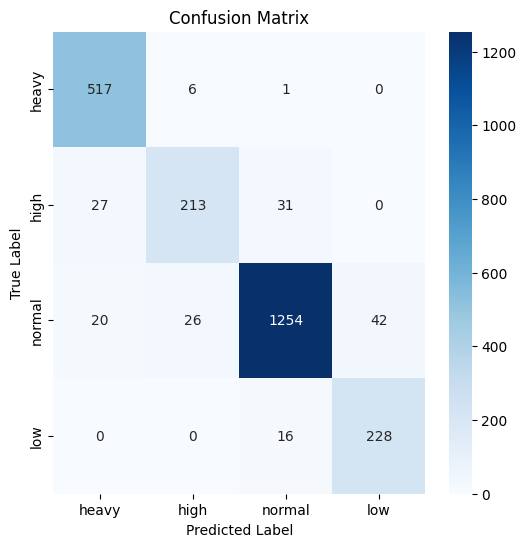

In [13]:
best_model.eval()

with torch.no_grad():
    outputs = best_model(X_test) 
    predictions = torch.argmax(outputs, dim=1)  

# Compute accuracy
accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
print(f"Model Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(y_test.numpy(), predictions.numpy())

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_mapping.keys(), yticklabels=target_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()